# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs

Authors: Bilal Kachir, Jakob Demmer, Mohammadreza Radnezhad |
Summer Term 2025     

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Perceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations
 3. Defining training helper functions and metrics
 4. Logistic Regression
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torchsummary


torch.manual_seed(42) # Set manual seed

In [ ]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [ ]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [ ]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.

100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


In [ ]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
## TODO: plot images with their labels after augmentations
import torchvision
def unnormalize(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1)
    return img * std + mean

def show_batch(dl):
    images, labels = next(iter(dl))
    print(labels[:100])
    # images, labels = next(iter(train_loader))
    images_100 = torch.clamp(unnormalize(images[:100]), 0.0, 1.0)

    # Create 10x10 grid
    grid = torchvision.utils.make_grid(images_100, nrow=10, padding=2)

    # Show grid
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

tensor([6, 0, 4, 1, 2, 7, 9, 4, 7, 8, 4, 5, 6, 0, 4, 2, 0, 1, 6, 1, 4, 3, 2, 3,
        2, 4, 0, 7, 5, 1, 8, 6, 3, 3, 7, 0, 4, 1, 7, 1, 3, 1, 1, 5, 6, 3, 7, 8,
        2, 3, 4, 8, 2, 1, 5, 6, 9, 9, 6, 9, 8, 3, 4, 7, 8, 7, 0, 2, 5, 2, 5, 8,
        6, 7, 4, 0, 5, 2, 0, 5, 1, 5, 5, 5, 1, 8, 6, 5, 7, 4, 9, 3, 2, 6, 6, 7,
        0, 1, 2, 3])


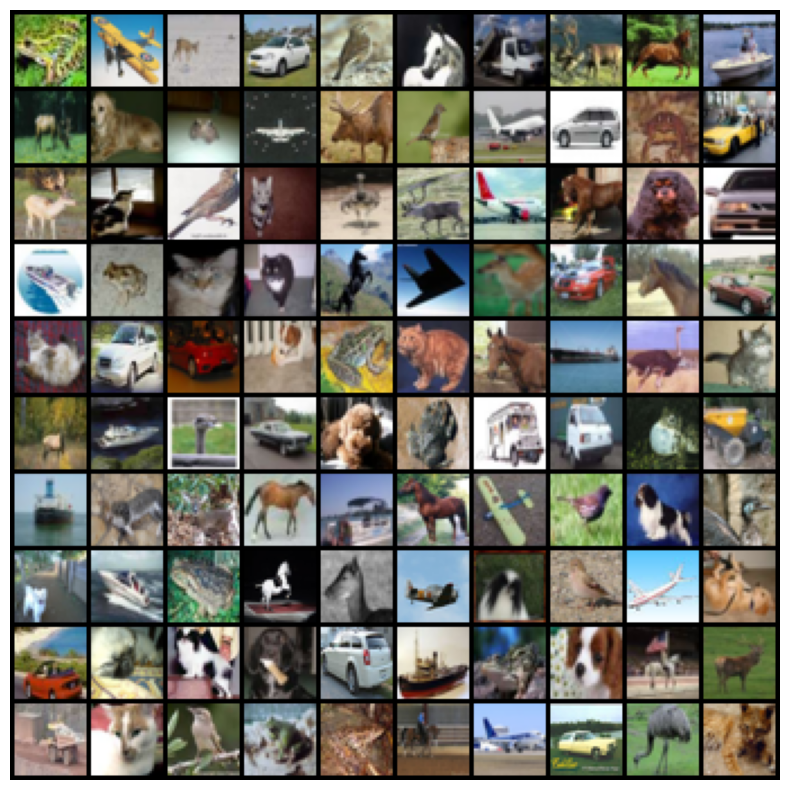

In [ ]:
show_batch(train_loader)

In [ ]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again.

In [ ]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total):
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    ratio = correct / total
    return ratio

In [ ]:
def train(dataloader, optimizer, model, loss_fn, device):
    """Train for one epoch and return mean loss & accucacy."""
    model.to(device).train()
    running_loss, correct, total = 0.0, 0, 0

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, target)
        loss.backward()
        optimizer.step()

        batch_size = data.size(0)
        running_loss += loss.item() * batch_size
        _, preds = outputs.max(1)
        correct += preds.eq(target).sum().item()
        total += batch_size

    mean_loss = running_loss / total
    acc = correct / total
    return mean_loss, acc

@torch.no_grad()
def validate(dataloader, model, loss_fn, device):
    """Validate once and return mean loss & accuracy."""
    model.to(device).eval()
    running_loss, correct, total = 0.0, 0, 0

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        loss = loss_fn(outputs, target)

        batch_size = data.size(0)
        running_loss += loss.item() * batch_size
        _, preds = outputs.max(1)
        correct += preds.eq(target).sum().item()
        total += batch_size

    mean_loss = running_loss / total
    acc = correct / total
    return mean_loss, acc

In [ ]:
#TODO: write a run_training function that
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2
from tqdm import trange


def run_training(model, optimizer, loss_fn, device,
                 num_epochs, train_loader, val_loader):
    """Runs train+val for each epoch, recording losses & accs."""
    train_losses, val_losses = [], []
    train_accs,   val_accs   = [], []

    master_bar = trange(num_epochs, desc="Epoch")

    for epoch in master_bar:
        tl, ta = train(   train_loader, optimizer, model, loss_fn, device)
        vl, va = validate(val_loader,   model,     loss_fn, device)

        train_losses.append(tl)
        train_accs.append(ta)
        val_losses.append(vl)
        val_accs.append(va)

        # Update the epoch‐level progress bar
        master_bar.set_postfix(
            train_loss=f"{tl:.4f}",
            val_loss=  f"{vl:.4f}",
            train_acc=f"{ta:.4f}",
            val_acc=  f"{va:.4f}"
        )

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """ method to calculate the confusion values """
    """
    Compute a confusion matrix for `model` on all data in `dataloader`.
    Returns a torch.LongTensor of shape (num_classes, num_classes)
    where entry (i, j) is the count of true‐class=i predicted‐as=j.
    """
    model = model.to(device).eval()

    # initialize confusion matrix
    cm = torch.zeros(num_classes, num_classes, dtype=torch.long, device=device)

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, preds = outputs.max(1)
            # accumulate counts
            for t, p in zip(target.view(-1), preds.view(-1)):
                cm[t.long(), p.long()] += 1

    # bring back to CPU for easy indexing/printing
    return cm.cpu()

## Logistic Regression   

In [ ]:
# TODO: define logistic regression model class and its necessary functions
class LogisticRegression(nn.Module):
    def __init__(self, input_dim: int = 3 * 32 * 32, num_classes: int = 10):
        """
        Parameters
        ----------
        input_dim : int
            Flattened size of one image (C × H × W). For CIFAR-10: 3*32*32 = 3072
        num_classes : int
            Number of target classes (CIFAR-10 ⇒ 10)
        """
        super().__init__()
        self.flatten = nn.Flatten()          # turns (N, 3, 32, 32) → (N, 3072)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.flatten(x)                  # (N, 3072)
        logits = self.fc(x)                  # (N, 10)
        return logits

In [ ]:
## TODO : Define network, put it to the device and train mode
logistic_regression = LogisticRegression().to(device).train()


In [ ]:
## Optimizer defined. We're going to use Adam since it's always the safe bet, and also for faster convergence.
optimizer_LR = torch.optim.Adam(logistic_regression.parameters(), lr=0.001)

### Define loss

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [ ]:
# TODO: define the loss function
loss_function = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 20
## TODO: run training over 20 epochs
train_losses_LR, val_losses_LR, train_accs_LR, val_accs_LR = run_training(logistic_regression, optimizer_LR, loss_function, device, num_epochs, train_loader, test_loader)


Epoch: 100%|██████████| 20/20 [05:11<00:00, 15.57s/it, train_acc=0.3994, train_loss=1.7615, val_acc=0.3800, val_loss=1.8451]


## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

Non-linear activations are essential because, without them, stacking linear layers is just another linear transformation—so we don’t improve the model or increase its complexity (“escape the linearity”). By inserting non-linearities, we “break” that linear chain, enabling the network to model curves, complex decision boundaries and learn hierarchical features, which is what gives deep nets their true expressive power.

In [ ]:
## TODO: Make the 4 layer MLP  with the following shapes :
## input_dim -> 2048 -> 512 -> 128 -> output_dim
## Use RELu as nonlinearity
## In the forward pass do not forget to flatten the input
class FourLayerMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.flatten(x) # to (N, input_dim)
        x = self.relu(self.fc1(x)) # to (N, 2048)
        x = self.relu(self.fc2(x)) # to (N, 512)
        x = self.relu(self.fc3(x)) # to (N, 128)
        logits = self.fc4(x) # to (N, output_dim)
        return logits


In [ ]:
## TODO: Define network, put it to device and train mode
input_dim = 3 * 32 * 32
output_dim = 10
mlp = FourLayerMLP(input_dim, output_dim)

In [ ]:
## TODO: Define optimizer and loss functions
loss_function = nn.CrossEntropyLoss()
optimizer_MLP = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [ ]:
## TODO: Train the MLP over 20 epochs
num_epochs = 20
train_losses_MLP, val_losses_MLP, train_accs_MLP, val_accs_MLP = run_training(mlp, optimizer_MLP, loss_function, device, num_epochs, train_loader, test_loader)

Epoch: 100%|██████████| 20/20 [05:36<00:00, 16.80s/it, train_acc=0.7698, train_loss=0.6494, val_acc=0.5596, val_loss=1.5433]


## Add L2 regularisation

In [ ]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.00005 is a good starting point for the regularization strength

L2_model = FourLayerMLP(input_dim, output_dim)
loss_function = nn.CrossEntropyLoss()
optimizer_MLP_L2 = torch.optim.Adam(L2_model.parameters(), lr=0.001, weight_decay=0.00005)


In [ ]:
## TODO: Retrain new model with regularization over 20 epochs
num_epochs = 20
train_losses_MLP_L2, val_losses_MLP_L2, train_accs_MLP_L2, val_accs_MLP_L2 = run_training(L2_model, optimizer_MLP_L2, loss_function, device, num_epochs, train_loader, test_loader)

Epoch: 100%|██████████| 20/20 [05:32<00:00, 16.65s/it, train_acc=0.7094, train_loss=0.8168, val_acc=0.5648, val_loss=1.3941]


## LeNet5

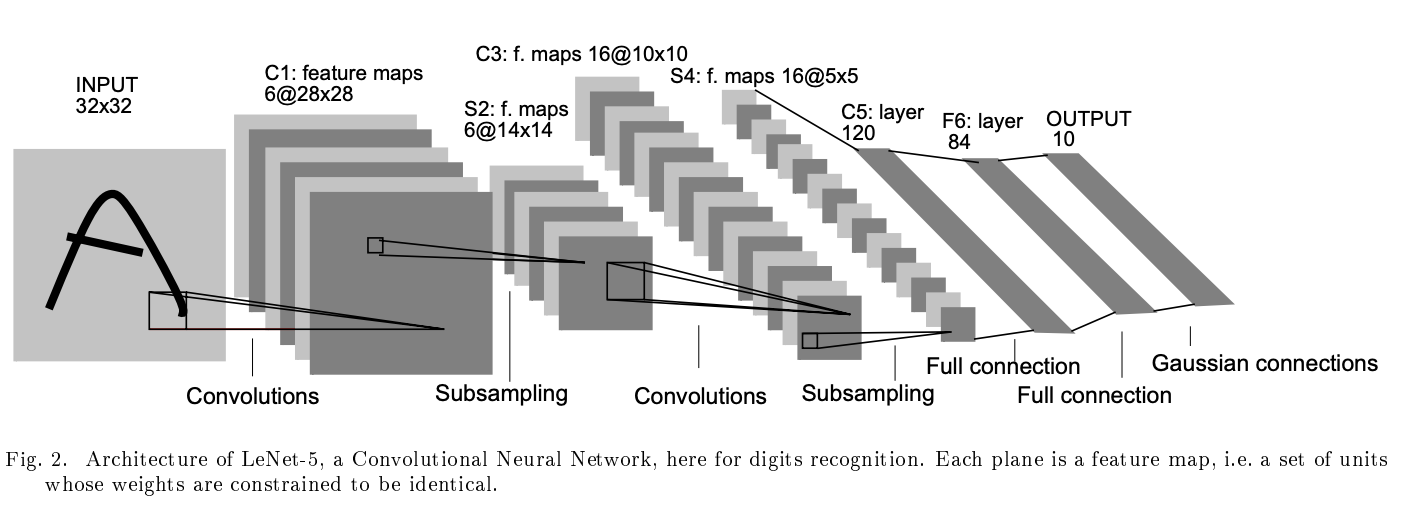

Let's implememt one of the classical convolutional network and apply it for CIFAR-10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implementation of LeNet5 has Tanh as nonlinearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        # default value stride = 1, padding = 0
        self.feature_extractor = nn.Sequential(
            # C1: 1@32×32 -> 6@28×28
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),

            # S2: 6@28×28 -> 6@14×14
            nn.AvgPool2d(kernel_size=2),

            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
            # C3: 6@14×14 -> 16@10×10
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),

            # S4: 16@10×10 -> 16@5×5
            nn.AvgPool2d(kernel_size=2),

            # C5: 16@5×5 -> 120@1×1
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            ## TODO: add ReLU nonlinearity and final classification linear layer
            # F6: 120 -> 84
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            # OUTPUT: 84 -> n_classes
            nn.Linear(in_features=84, out_features=n_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
## TODO: define network, put it to the device and train mode
network = LeNet5(n_classes=10, in_channels=3).to(device).train() # 3 channels for RGB, 10 classes


For a quick overview of models, torchsummary.summary is quite helpful  
comment: You can also import predefined architectures from `torchvision` and run `torchsummary.summary` on them to get a quick overview

In [ ]:
## TODO: run torchsummary.summary on the LeNet5 and your MLP model. What do you see?
import torchvision
torchsummary.summary(network, (3, 32, 32))
torchsummary.summary(mlp, (3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              ReLU-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [ ]:
## TODO: define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer_conv = torch.optim.Adam(network.parameters(), lr=0.001)

In [ ]:
## TODO: train with 20 epochs
num_epochs = 20

train_losses_conv, val_losses_conv, train_accs_conv, val_accs_conv = run_training(network, optimizer_conv, loss_function, device, num_epochs, train_loader, test_loader)

Epoch: 100%|██████████| 20/20 [05:40<00:00, 17.01s/it, train_acc=0.6765, train_loss=0.9152, val_acc=0.6424, val_loss=1.0212]


## Analysis

In [ ]:
epochs = range(1, num_epochs + 1)


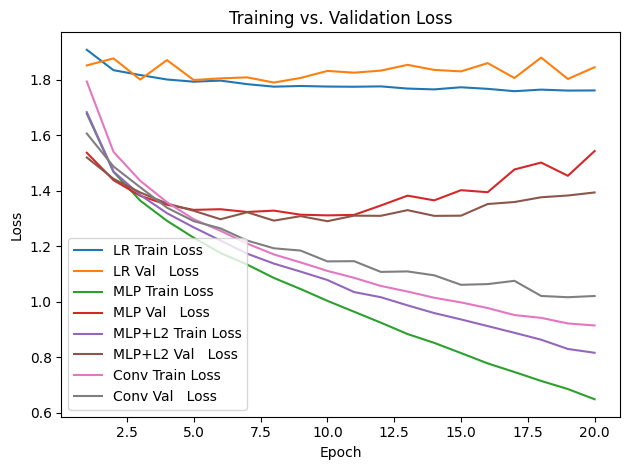

In [ ]:
## TODO: Plot both train and val losses for all models.
## What do you see?

plt.figure()
plt.plot(epochs, train_losses_LR,    label="LR Train Loss")
plt.plot(epochs, val_losses_LR,      label="LR Val   Loss")
plt.plot(epochs, train_losses_MLP,   label="MLP Train Loss")
plt.plot(epochs, val_losses_MLP,     label="MLP Val   Loss")
plt.plot(epochs, train_losses_MLP_L2, label="MLP+L2 Train Loss")
plt.plot(epochs, val_losses_MLP_L2,   label="MLP+L2 Val   Loss")
plt.plot(epochs, train_losses_conv,  label="Conv Train Loss")
plt.plot(epochs, val_losses_conv,    label="Conv Val   Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

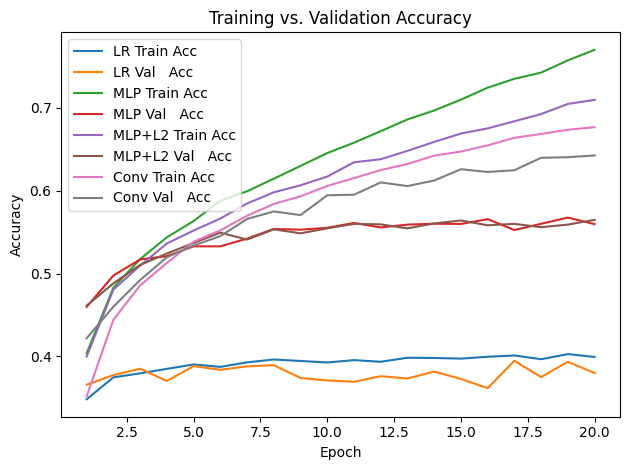

In [ ]:
## TODO: Plot both train and val accuracies for all models.
## What do you see?
plt.figure()
plt.plot(epochs, train_accs_LR,    label="LR Train Acc")
plt.plot(epochs, val_accs_LR,      label="LR Val   Acc")
plt.plot(epochs, train_accs_MLP,   label="MLP Train Acc")
plt.plot(epochs, val_accs_MLP,     label="MLP Val   Acc")
plt.plot(epochs, train_accs_MLP_L2, label="MLP+L2 Train Acc")
plt.plot(epochs, val_accs_MLP_L2,   label="MLP+L2 Val   Acc")
plt.plot(epochs, train_accs_conv,  label="Conv Train Acc")
plt.plot(epochs, val_accs_conv,    label="Conv Val   Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

the logistic regression train and validation are not good and the validation is worse than train in the linear regression model.
Normal MLP is overfitting on the train set but does the worst in the validation between the remeaning models except for the linear regression.
with regularizaition we perfrom a little bit better on the validation set but still the loss is higher than conv_net.
Convnet has the best result among these models and the validation curve is like the training curve which means a good training.

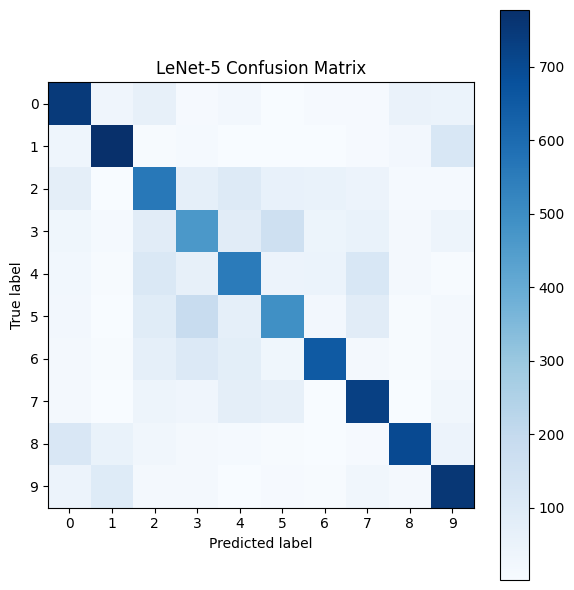

In [ ]:
## TODO: Plot the confusion matrix for LeNet5
# now your existing function will see that name
cm = calc_confusion_values(test_loader, network, device)

plt.figure(figsize=(6,6))
plt.imshow(cm.cpu(), interpolation='nearest', cmap='Blues')
plt.title("LeNet-5 Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()

ticks = range(num_classes)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.tight_layout()
plt.show()

## Questions
How did regularization change the performance of the MLP? Why?

* It redueces the train loss of the MLP but the performance in the validation deos not exceed in the validation. This trend suggests that the model of the MLP can not learn much more of the images. (the Convnet is a better solution)

Explain the confusion matrix for LeNet5. What do you see there?
* Most true-class labels lie on the main diagonal -> good accuracy. There are some boxes off the diagonal where errors cluster. This is possibly among visually similar classes.

Explain the difference in performance between linear regression, MLP, and LeNet5.
* Linear regression: Only a single linear separator struggles to learn complex class boundaries in the pixel space.
* MLP: MLP uses non-linear activations and multiple layers. Thus, it can learn more complex mappings. It still treats every pixel independently and has many parameters.
* LeNet-5: Uses convolutional layers to exploit spatial structure. Thus, it can get better feature extraction with fewer parameters and superior accuracy on images.

Why are convolutions better suited for pictures? Which properties of images do they exploit?
* the spatial features which can happen the in 2d dimension should be understand in the 2d dimensions and slowly transform into the d dimension, in Convnet this happens. In other models we have a 1d array representation of our data at the begining which already destroyed the 2d information of the data.

Is it important to redefine an optimizer for each different model, training? What about loss functions?
* yes, we should redefine the optimizer since our parameters are differnet in each optimizer (depeneds to our model). Also we need regularization like weight decay in the MLP+L2 which should be modified in the optimizer
* No, the loss function is the cross_entropy and is similar for all the models.

## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
